# Bayesian Inference for Accelerated Randomized Benchmarking

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.tools.monitor import job_monitor
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error
from qiskit import  QuantumRegister, QuantumCircuit

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

import copy
import time

# import the bayesian packages
import pymc3 as pm
import arviz as az

In [2]:
# initialize the Bayesian extension
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# From here to be moved in .py file(s)

In [3]:
def obtain_priors_and_data_from_fitter(rbfit,printout = True):
    
    
    m_gates = copy.deepcopy(nCliffs)
    # We choose the count matrix corresponding to 2 Qubit RB
    Y = (np.array(rbfit._raw_data[0])*shots).astype(int)
    
    # alpha prior and bounds 
    alpha_ref = rbfit._fit[0]['params'][1]    
    #alpha_lower = alpha_ref - 6*rbfit._fit[0]['params_err'][1] 
    #alpha_upper = alpha_ref + 6*rbfit._fit[0]['params_err'][1] 
    alpha_lower = .95*alpha_ref 
    alpha_upper = min(1.05*alpha_ref,1.0) 
    # priors for A anbd B
    mu_AB = np.delete(rbfit._fit[0]['params'],1)
    cov_AB=np.delete(rbfit._fit[0]['params_err'],1)**2
    
    # prior for sigma theta:
    sigma_theta = 0.004 # WIP   
    if printout:
        print("priors:\nalpha_ref",alpha_ref)
        print("alpha_lower", alpha_lower, "alpha_upper", alpha_upper)
        print("A,B", mu_AB, "\ncov A,B", cov_AB)
        print("sigma_theta", sigma_theta)
    
    return m_gates, Y, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta

In [4]:
# modified for accelerated BM with EPCest as extra parameter
def get_bayesian_model(model_type,Y,shots,m_gates,mu_AB,cov_AB,
                            alpha_lower=0.5,alpha_upper=0.999,alpha_testval=0.9,                            
                            p_lower=0.9,p_upper=0.999,p_testval=0.95,
                            RvsI=None,IvsR=None,sigma_theta=0.004): 
# Bayesian model
# from https://iopscience.iop.org/arti=RvsI, cle/10.1088/1367-2630/17/1/013042/pdf 
# see https://docs.pymc.io/api/model.html
    
    RB_model = pm.Model()
    with RB_model:
        total_shots = np.full(Y.shape, shots)
       
        #Priors for unknown model parameters
        alpha = pm.Uniform("alpha",lower=alpha_lower,
                           upper=alpha_upper, testval = alpha_ref)
        
        BoundedMvNormal = pm.Bound(pm.MvNormal, lower=0.0)
        
        AB = BoundedMvNormal("AB", mu=mu_AB,testval = mu_AB,
                         cov= np.diag(cov_AB),
                         shape = (2))
        
        if model_type == "hierarchical":
            GSP = AB[0]*alpha**m_gates + AB[1]
            theta = pm.Beta("GSP",
                             mu=GSP,
                             sigma = sigma_theta,
                             shape = Y.shape[1])
            # Likelihood (sampling distribution) of observations    
            p = pm.Binomial("Counts_h", p=theta, observed=Y,
                            n = total_shots) 
        
        elif model_type == "tilde":
            p_tilde = pm.Uniform("p_tilde",lower=p_lower,
                               upper=p_upper, testval = p_testval)
            GSP = AB[0]*(RvsI*alpha**m_gates + IvsR*(alpha*p_tilde)**m_gates) + AB[1]
            # Likelihood (sampling distribution) of observations    
            p = pm.Binomial("Counts_t", p=GSP, observed=Y,
                            n = total_shots) 
                       
        
        else:  # defaul model "pooled"      
            GSP = AB[0]*alpha**m_gates + AB[1]        
            # Likelihood (sampling distribution) of observations    
            p = pm.Binomial("Counts_p", p=GSP, observed=Y,
                            n = total_shots) 

    return RB_model

In [5]:
def get_bayesian_model_hierarchical(model_type,Y): # modified for accelerated BM with EPCest as extra parameter
# Bayesian model
# from https://iopscience.iop.org/article/10.1088/1367-2630/17/1/013042/pdf 
# see https://docs.pymc.io/api/model.html
    
    RBH_model = pm.Model()
    with RBH_model:
        
        #Priors for unknown model parameters
        alpha = pm.Uniform("alpha",lower=alpha_lower,
                           upper=alpha_upper, testval = alpha_ref)
        
        BoundedMvNormal = pm.Bound(pm.MvNormal, lower=0.0)
        
        AB = BoundedMvNormal("AB", mu=mu_AB,testval = mu_AB,
                         cov= np.diag(cov_AB),
                         shape = (2))

        # Expected value of outcome                
           
        GSP = AB[0]*alpha**m_gates + AB[1]
        
        
        total_shots = np.full(Y.shape, shots)
        theta = pm.Beta("GSP",
                     mu=GSP,
                     sigma = sigma_theta,
                     shape = Y.shape[1])
        
        # Likelihood (sampling distribution) of observations    
        p = pm.Binomial("Counts", p=theta, observed=Y,
                            n = total_shots) 

    return RBH_model

In [6]:
def get_trace(RB_model):
    # Gradient-based sampling methods
    # see also: https://docs.pymc.io/notebooks/sampler-stats.html
    # and https://docs.pymc.io/notebooks/api_quickstart.html
    with RB_model:   
        trace= pm.sample(draws = 2000, tune= 10000, target_accept=0.9, return_inferencedata=True)    

    with RB_model:
        az.plot_trace(trace);
        
    return trace

In [7]:
def get_summary(RB_model, trace, hdi_prob=.94, kind='all'):
    with RB_model:
        #  (hdi_prob=.94 is default)
        az_summary = az.summary(trace, round_to=4,  hdi_prob=hdi_prob, kind=kind )  
        
    return az_summary

In [8]:
# obtain EPC from alpha (used by plot_posterior)
def alpha_to_EPC(alpha):
        return 3*(1-alpha)/4   

In [9]:
def get_EPC_and_legends(rbfit,azs):
    EPC_Bayes = alpha_to_EPC(azs['mean']['alpha'])
    EPC_Bayes_err = EPC_Bayes - alpha_to_EPC(azs['mean']['alpha']+azs['sd']['alpha'])
    Bayes_legend ="EPC Bayes {0:.5f} ({1:.5f})".format(EPC_Bayes, EPC_Bayes_err)
    Fitter_legend ="EPC Fitter {0:.5f} ({1:.5f})".format(rbfit.fit[0]['epc']\
                                                        ,rbfit._fit[0]['epc_err'])
    if pred_epc > 0.0:
        pred_epc_legend = "EPC predicted {0:.5f}".format(pred_epc)
    else:
        pred_epc_legend = ''
    return EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend, pred_epc_legend
    
def EPC_compare_fitter_to_bayes(RB_model, azs, trace,m_name,rbfit):
    EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend, pred_epc_legend = get_EPC_and_legends(rbfit,azs)
    with RB_model:
        az.plot_posterior(trace,  var_names=['alpha'], round_to=4,
                          transform = alpha_to_EPC, point_estimate=None)
        plt.title("Error per Clifford  "+RB_process+"  device: "+hardware
                  +'  backend: '+backend.name()+'  model:'+m_name,
                  fontsize=12)
        plt.axvline(x=alpha_to_EPC(alpha_ref),color='red')
        if pred_epc > 0.0:
            plt.axvline(x=pred_epc,color='green') 
            plt.legend((Bayes_legend, "Higher density interval",Fitter_legend, pred_epc_legend), fontsize=10)
        else:
            plt.legend((Bayes_legend, "Higher density interval",Fitter_legend), fontsize=10 )
        
        plt.show()

In [10]:
def GSP_compare_fitter_to_bayes(RB_model, azs,m_name,rbfit):
    EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend,_ = get_EPC_and_legends(rbfit,azs)
    # plot ground state population ~ Clifford length
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

    axes.set_ylabel("Ground State Population")
    axes.set_xlabel("Clifford Length")
    axes.plot(m_gates, np.mean(Y/shots,axis=0), 'r.')
    axes.plot(m_gates,azs['mean']['AB[0]']*azs['mean']['alpha']**m_gates+azs['mean']['AB[1]'],'--')
    #axes.plot(m_gates,azs['mean']['GSP'],'--') # WIP
    #axes.errorbar(m_gates, azs['mean']['GSP'], azs['sd']['GSP'], linestyle='None', marker='^') # WIP
    axes.plot(m_gates,mu_AB[0]*np.power(alpha_ref,m_gates)+mu_AB[1],':') 
    for i_seed in range(nseeds):
        plt.scatter(m_gates-0.25, Y[i_seed,:]/shots, label = "data", marker="x")
    axes.legend(["Mean Observed Frequencies",
                 "Bayesian Model\n"+Bayes_legend,
                 "Fitter Model\n"+Fitter_legend],fontsize=12)
    axes.set_title(RB_process+"  device: "+hardware+'  backend: '+backend.name()+'  model:'+m_name,
                   fontsize=14) # WIP
    

In [11]:
def get_predicted_EPC(error_source):

    #Count the number of single and 2Q gates in the 2Q Cliffords
    gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
    for basis_gate in basis_gates:
        print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                      np.mean([gates_per_cliff[rb_pattern[0][0]][basis_gate],
                                                               gates_per_cliff[rb_pattern[0][1]][basis_gate]])))
    # Calculate the predicted epc
    # from the known depolarizing errors on the simulation
    if error_source == "depolarization":  
        # Error per gate from noise model
        epgs_1q = {'u1': 0, 'u2': p1Q/2, 'u3': 2*p1Q/2}
        epg_2q = p2Q*3/4
        pred_epc = rb.rb_utils.calculate_2q_epc(
            gate_per_cliff=gates_per_cliff,
            epg_2q=epg_2q,
            qubit_pair=[0, 2],
            list_epgs_1q=[epgs_1q, epgs_1q])

    # using the predicted primitive gate errors from the coherence limit
    if error_source == "from_T1_T2": 
        # Predicted primitive gate errors from the coherence limit
        u2_error = rb.rb_utils.coherence_limit(1,[t1],[t2],gate1Q)
        u3_error = rb.rb_utils.coherence_limit(1,[t1],[t2],2*gate1Q)
        epg_2q = rb.rb_utils.coherence_limit(2,[t1,t1],[t2,t2],gate2Q)
        epgs_1q = {'u1': 0, 'u2': u2_error, 'u3': u3_error}
        pred_epc = rb.rb_utils.calculate_2q_epc(
            gate_per_cliff=gates_per_cliff,
            epg_2q=epg_2q,
            qubit_pair=[0, 1],
            list_epgs_1q=[epgs_1q, epgs_1q])
    return pred_epc

In [12]:
def get_and_run_seeds(rb_circs, shots, backend, coupling_map,
                      basis_gates, noise_model, retrieve_list=[]):   
    #basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
    result_list = []
    transpile_list = []

    for rb_seed,rb_circ_seed in enumerate(rb_circs):
        print('Compiling seed %d'%rb_seed)
        rb_circ_transpile = qiskit.transpile(rb_circ_seed,
                                             optimization_level=0,
                                             basis_gates=basis_gates)
        print('Runing seed %d'%rb_seed)

        if retrieve_list == []:
            if noise_model == None: # this indicates harware run          
                job = qiskit.execute(rb_circ_transpile, 
                                 shots=shots,
                                 backend=backend,
                                 coupling_map=coupling_map,
                                 basis_gates=basis_gates)
            else:
                job = qiskit.execute(rb_circ_transpile, 
                                 shots=shots,
                                 backend=backend,
                                 coupling_map=coupling_map,
                                 noise_model=noise_model,
                                 basis_gates=basis_gates)                        
            job_monitor(job)
        else: 
            job = backend.retrieve_job(retrieve_list[rb_seed])

        result_list.append(job.result())
        transpile_list.append(rb_circ_transpile)    

    print("Finished  Jobs")
    return result_list, transpile_list

In [13]:
def get_count_data(result_list):
### another way to obtain the observed counts
#corrected for accomodation pooled data from 2Q and 3Q interleave processes
    list_bitstring = ['00', '000', '100'] # all bistring with 00 as last characters
    Y_list = []
    for rbseed, result in enumerate(result_list):
        row_list = []
        for c_index, c_value in enumerate(nCliffs) :  
            total_counts = 0
            for key,val in result.get_counts()[c_index].items():
                if  key in list_bitstring:
                    total_counts += val
                    #print(key,val,total_counts)
            row_list.append(total_counts)
        Y_list.append(row_list)    
    return np.array(Y_list)    

In [14]:
# This section for the LS fit in this model pooling
# data from 2Q and 3Q interleave processes

from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * b ** x + c
def epc_fitter_when_mixed_2Q_3Q_RB(X,Y1,Y2,shots,check_plot=False):

    xdata = np.array(list(X)*Y1.shape[0]) # must be something simpler
    ydata1 = np.ravel(Y1)/shots     
    popt, pcov = curve_fit(func, xdata, ydata1)
    perr= np.sqrt(np.diag(pcov))
    
    ydata2 = np.ravel(Y2)/shots  
    popt2, pcov2 = curve_fit(func, xdata, ydata2)
    perr2= np.sqrt(np.diag(pcov2))
    
    if check_plot:
        import matplotlib.pyplot as plt
        plt.plot(xdata, ydata1, 'bx', label='Reference')
        plt.plot(xdata, ydata2, 'r+', label='Interleave')
        plt.plot(X, np.mean(Y1,axis=0)/shots, 'b-', label=None)
        plt.plot(X, np.mean(Y2,axis=0)/shots, 'r-', label=None)
        plt.ylabel('Population of |00>')
        plt.xlabel('Number of Cliffords')
        plt.legend()
        plt.show()
        
        print(popt[1])
        print(perr[1])
        print(popt2[1])
        print(perr2[1])

    epc_est_fitter = 3*(1 - popt2[1]/popt[1])/4
    epc_est_fitter_err = 3*(popt2[1]/popt[1])/4 * (np.sqrt(perr[1]**2 + perr2[1]**2))
    return epc_est_fitter, epc_est_fitter_err

# END PART TO BE MOVED

# Back to the notebook project

## Parameters of the RB Run <a name='select_params_RB'></a>


- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In [15]:
RB_process = "3_Q RB" # choice from "2_Q RB" or "3_Q RB"
# "2-3_Q RB" not used in this demo
if RB_process in ["3_Q RB","2-3_Q RB"] : 
    #Number of qubits
    nQ = 3
    #There are 3 qubits: Q0,Q1,Q2.
    #2Q RB on Q0,Q2 and 1Q RB on Q1
    rb_pattern = [[1,2],[3]] # because 3 qubits
    #Do three times as many 1Q Cliffords    
    length_multiplier = [1,3]
    #Interleaved Clifford gates (2-qubits and 1-qubit)
    interleaved_gates = [['cx 0 1'],['x 2']]

else:
    #Number of qubits
    nQ = 2
    #There are 2 qubits: Q0,Q1.
    #2Q RB Q0,Q1
    rb_pattern = [[1,2]]
    length_multiplier = 1
    interleaved_gates = [['cx 0 1']]    

In [16]:
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)

#Number of seeds (random sequences)
nseeds=8
#retrieve_list=ibmq_belem_list
#retrieve_list=ibmq_lima_list
retrieve_list=[] # if you want a new runs on hardware or if no hardware
if retrieve_list != []:
    nseeds = len(retrieve_list)

In [17]:
qregs_02 = QuantumRegister(2)
circ_02 = QuantumCircuit(qregs_02, name='circ_02')
#circ_02.h(qregs_02[0]) # booptrap! WIP!
circ_02.cx(qregs_02[0], qregs_02[1])
circ_02.draw()

q0_0: ──■──
      ┌─┴─┐
q0_1: ┤ X ├
      └───┘

In [18]:
qregs_1 = QuantumRegister(1)
circ_1 = QuantumCircuit(qregs_1, name='circ_1')
circ_1.x(qregs_1[0]) # booptrap! WIP!
circ_1.draw()

┌───┐
q1_0: ┤ X ├
      └───┘

## Generate the RB sequences <a name='gen_RB_seq'></a>

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

In [19]:
rb_opts = {}
rb_opts['rand_seed'] = 61946
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
#rb_opts['align_cliffs'] = True
if RB_process in ["3_Q RB","2-3_Q RB"]:
    rb_opts['interleaved_elem'] = [circ_02, circ_1]
if RB_process == "2_Q RB":
     rb_opts['interleaved_elem'] = [circ_02]
rb_original_circs, xdata, rb_interleaved_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [20]:
#Original RB circuits
print (rb_original_circs[0][0])

                                                                             »
qr_0: ───────────────────────────────────────────────────────────────────────»
      ┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░ ┌─────┐┌───┐       ┌───┐»
qr_1: ┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░─┤ SDG ├┤ H ├───■───┤ H ├»
      └┬───┬┘├───┤┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤ ░ ├─────┤├───┤ ┌─┴─┐ ├───┤»
qr_2: ─┤ Z ├─┤ H ├┤ X ├┤ SDG ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ SDG ├┤ H ├─┤ X ├─┤ H ├»
       ├───┤ ├───┤├───┤└──░──┘├───┤├───┤└─░─┘├───┤ ░ ├─────┤├───┤┌┴───┴┐├───┤»
qr_3: ─┤ S ├─┤ H ├┤ S ├───░───┤ X ├┤ H ├──░──┤ H ├─░─┤ SDG ├┤ H ├┤ SDG ├┤ X ├»
       └───┘ └───┘└───┘   ░   └───┘└───┘  ░  └───┘ ░ └─────┘└───┘└─────┘└───┘»
cr: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                
«qr_0: ──────────────────────────
«      ┌───┐     ┌───┐┌───┐┌─┐   
«qr_1: ┤ S ├──■──┤ H ├┤ S ├┤M

In [21]:
#Interleaved RB circuits
print (rb_interleaved_circs[0][0])

                                                                              »
qr_0: ────────────────────────────────────────────────────────────────────────»
      ┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░       ░      ┌─────┐┌───┐»
qr_1: ┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░───■───░───■──┤ SDG ├┤ H ├»
      └┬───┬┘├───┤┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐├─────┤├───┤»
qr_2: ─┤ Z ├─┤ H ├┤ X ├┤ SDG ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ X ├─░─┤ X ├┤ SDG ├┤ H ├»
       ├───┤ ├───┤├───┤└──░──┘├───┤└─░─┘├───┤├───┤ ░ ├───┤ ░ ├───┤└──░──┘├───┤»
qr_3: ─┤ S ├─┤ H ├┤ S ├───░───┤ X ├──░──┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├───░───┤ X ├»
       └───┘ └───┘└───┘   ░   └───┘  ░  └───┘└───┘ ░ └───┘ ░ └───┘   ░   └───┘»
cr: 3/════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                              
«qr_0: ────────────────────────────────────────
«            ┌───┐ ┌───┐

### Determine hardware for noise model simulation or real device experiment

In [22]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
#provider.backends()

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [23]:
device = provider.get_backend('ibmq_santiago') # type here hardware backend
properties = device.properties()
coupling_map = device.configuration().coupling_map

In [24]:
# use a noise model corresponding to the chosen real device backend
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
hardware = device.name() 
backend = Aer.get_backend('qasm_simulator')
shots = 2**9
noise_model = NoiseModel.from_backend(properties)
retrieve_list=[] # nothing to retrieve

 # Execute the RB sequences

In [25]:
original_result_list, original_transpile_list = get_and_run_seeds(rb_circs=rb_original_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Job Status: job has successfully run
Compiling seed 1
Runing seed 1
Job Status: job has successfully run
Compiling seed 2
Runing seed 2
Job Status: job has successfully run
Compiling seed 3
Runing seed 3
Job Status: job has successfully run
Compiling seed 4
Runing seed 4
Job Status: job has successfully run
Compiling seed 5
Runing seed 5
Job Status: job has successfully run
Compiling seed 6
Runing seed 6
Job Status: job has successfully run
Compiling seed 7
Runing seed 7
Job Status: job has successfully run
Finished  Jobs


In [26]:
interleaved_result_list, interleaved_transpile_list = get_and_run_seeds(rb_circs=rb_interleaved_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Job Status: job has successfully run
Compiling seed 1
Runing seed 1
Job Status: job has successfully run
Compiling seed 2
Runing seed 2
Job Status: job has successfully run
Compiling seed 3
Runing seed 3
Job Status: job has successfully run
Compiling seed 4
Runing seed 4
Job Status: job has successfully run
Compiling seed 5
Runing seed 5
Job Status: job has successfully run
Compiling seed 6
Runing seed 6
Job Status: job has successfully run
Compiling seed 7
Runing seed 7
Job Status: job has successfully run
Finished  Jobs


### Calculate the interleaved gate error fidelity

From the values of $\alpha$ and $\alpha_C$ we obtain the gate error of the interleaved Clifford $c$, and $r_C=1-$(average gate fidelity of the interleaved Clifford $C$), is estimated by:
$$ EPC^{est} = r_C^{est} = \frac{(2^n-1)(1-\alpha/\alpha_C)}{2^n}$$
and must lie in the range given by certain systematic error bounds: 
$$[r_C^{est}-E,r_C^{est}+E]$$ 
for each of the patterns.

In [27]:
###### Create the original and interleaved RB fitter
original_rb_fit = rb.RBFitter(original_result_list, xdata, rb_opts['rb_pattern'])
interleaved_rb_fit = rb.RBFitter(interleaved_result_list, xdata, rb_opts['rb_pattern'])

###### mkd
alpha_f = original_rb_fit._fit[0]['params'][1] 
alphC_f =  interleaved_rb_fit._fit[0]['params'][1] 
alpha_f_err = original_rb_fit._fit[0]['params_err'][1] 
alphC_f_err =  interleaved_rb_fit._fit[0]['params_err'][1] 
epc_est_f = 3*(1 - alphC_f/alpha_f)/4
epc_est_f_err = 3*(alphC_f/alpha_f)/4*(np.sqrt(alpha_f_err**2 + alphC_f_err**2))

In [28]:
#Calculate the joint fitter
joint_rb_fit = rb.InterleavedRBFitter(original_result_list, interleaved_result_list, xdata, rb_opts['rb_pattern'])

##  Bayesian inference

###  Accelerated RB

model: [equation 5 in this paper](https://arxiv.org/abs/1404.5275) 

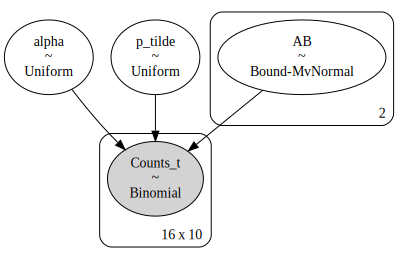

In [29]:
m_gates, Y1, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    obtain_priors_and_data_from_fitter(rbfit = original_rb_fit, printout = False) 
_, Y2, _, _, _, _, _, _ =\
    obtain_priors_and_data_from_fitter(rbfit = interleaved_rb_fit, printout = False)

Y = np.vstack((Y1,Y2))
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))

tilde = get_bayesian_model("tilde",Y=Y,shots=shots,m_gates=m_gates,mu_AB=mu_AB,cov_AB=cov_AB,RvsI=RvsI,IvsR=IvsR)
pm.model_to_graphviz(tilde)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_tilde, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 95 seconds.


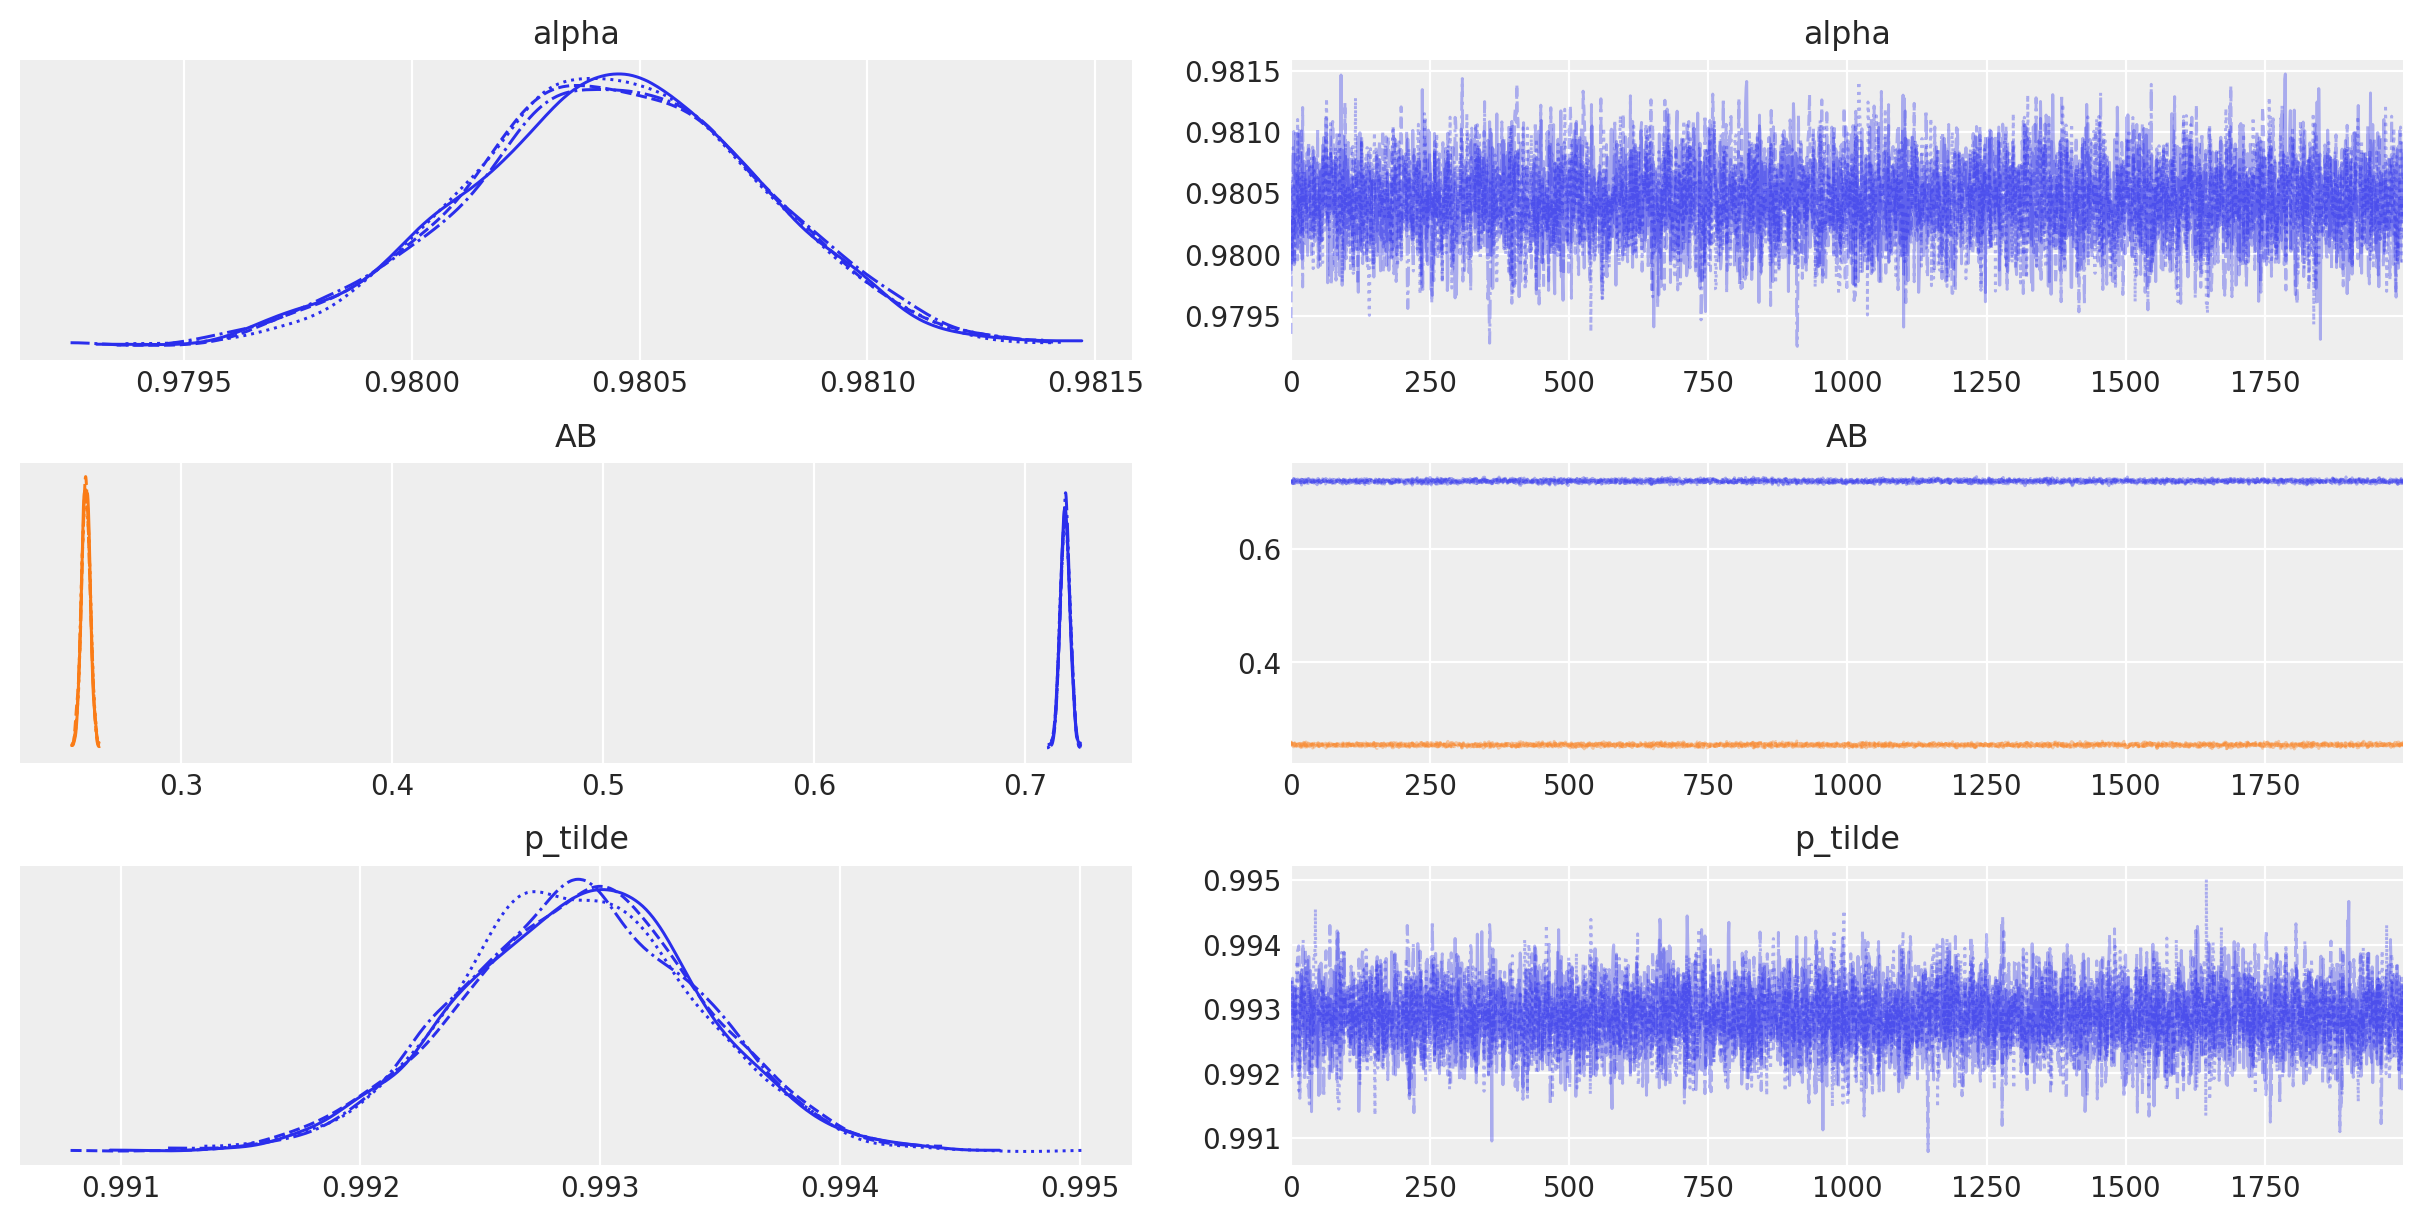

In [30]:
trace_t = get_trace(tilde)

In [31]:
azt_summary = get_summary(tilde, trace_t)
azt_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9804,0.0003,0.9799,0.9811,0.0,0.0,5451.8679,5204.9567,1.0004
AB[0],0.7190,0.0023,0.7149,0.7234,0.0,0.0,5376.2289,5518.3855,1.0008
AB[1],0.2549,0.0021,0.2510,0.2588,0.0,0.0,4817.1480,4780.6109,1.0000
p_tilde,0.9929,0.0005,0.9920,0.9938,0.0,0.0,6287.7557,5226.5261,1.0001


# Final comparison

In [32]:
# for refering the interleaved gate in the title of the graphs
intl_g=str(interleaved_gates[0][0][0:2])+str(rb_pattern[0][0:2])
if RB_process in ["3_Q RB","2-3_Q RB"] :
    intl_g=intl_g+"<"+str(interleaved_gates[1][0][0:1]+str(rb_pattern[1][0:2]))

In [38]:
# calibration made april 21, 2021 , 12AM 
epc_calib = 5.453E-3 # enter here the read calibration error of the device, 0.0 if None WIP

epc_est_fitter = joint_rb_fit.fit_int[0]["epc_est"]
epc_est_fitter_err = joint_rb_fit.fit_int[0]["epc_est_err"]

epc_est_a =3/4*(1 - azt_summary['mean']['p_tilde'])
epc_est_a_err = 3/4* (azt_summary['sd']['p_tilde'])

print("      fitter   2xpooled  calibration")
print("EPC   {0:.5f}  {1:.5f}   {2:.5f} ".format(epc_est_fitter,  epc_est_a, epc_calib))
print("ERROR {0:.5f}  {1:.5f}      --- ".format(epc_est_fitter_err, epc_est_a_err))

      fitter   2xpooled  calibration
EPC   0.00549  0.00532   0.00545 
ERROR 0.00081  0.00038      --- 


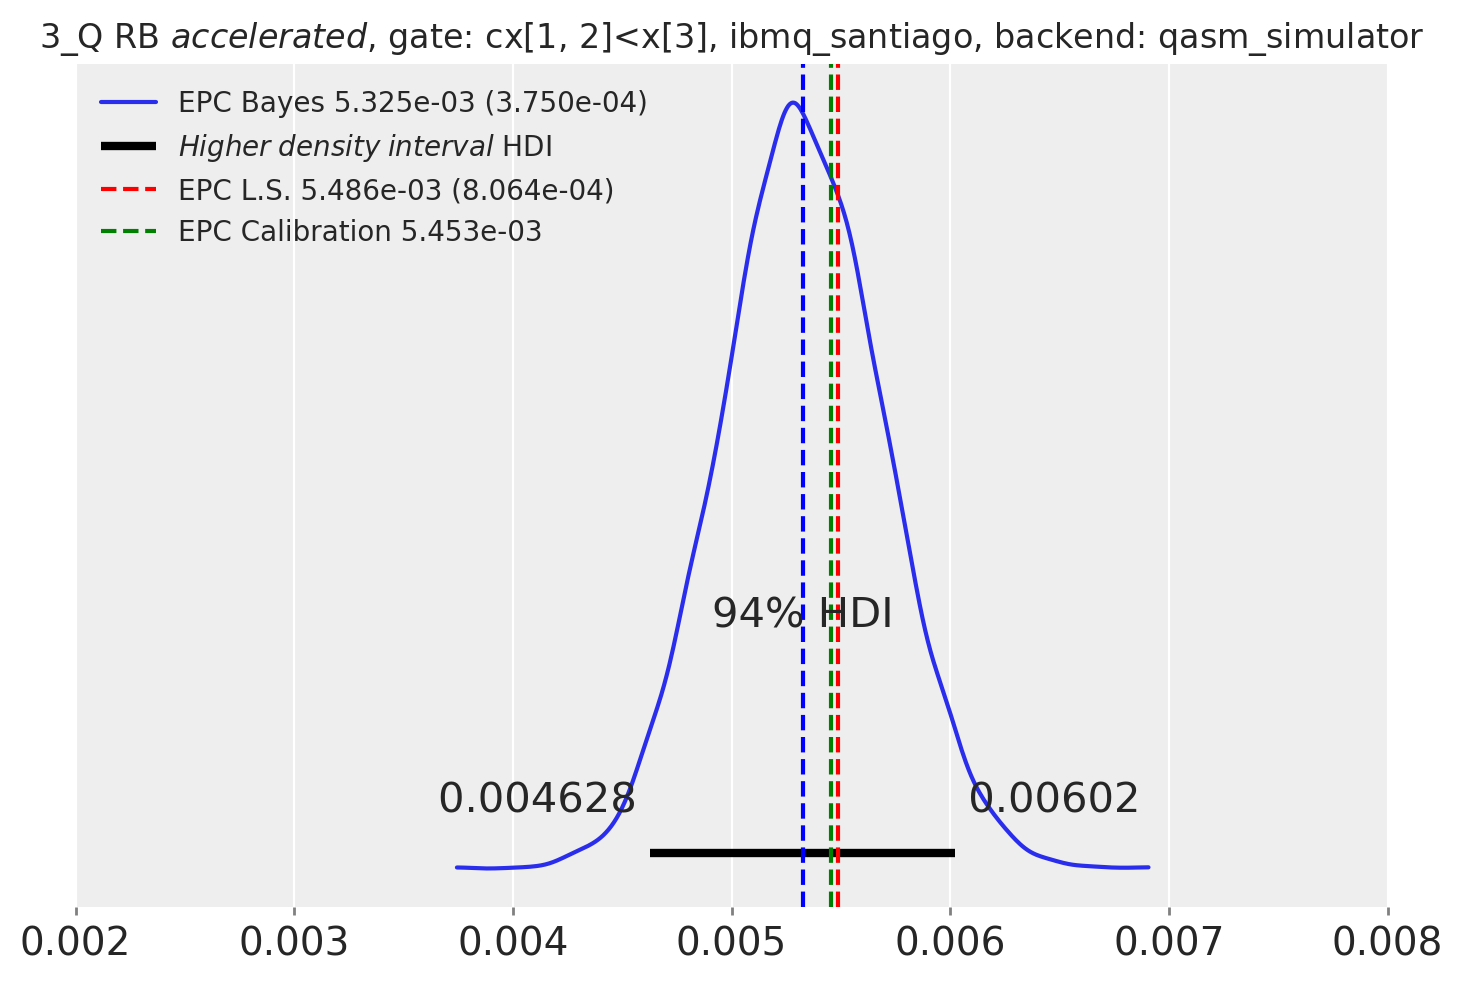

In [39]:
import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

with tilde:
        ax = az.plot_posterior(trace_t,  var_names=['p_tilde'], round_to=4, point_estimate=None, 
                          transform =  alpha_to_EPC)
        ax.set_xlim(0.002, 0.008)
        plt.axvline(x=epc_est_fitter,color='red',ls="--")
        if epc_calib > 0.0:
            plt.axvline(x=epc_calib,color='green',ls="--")
        plt.axvline(x=epc_est_a,color='blue',ls="--")
        plt.title(RB_process +' $accelerated$, gate: ' + intl_g\
                  +", "+hardware+', backend: '+backend.name(),
               fontsize=12)
        Bayes_legend ="EPC Bayes {0:1.3e} ({1:1.3e})".format(epc_est_a, epc_est_a_err)
        Fitter_legend ="EPC L.S. {0:1.3e} ({1:1.3e})".format(epc_est_fitter, epc_est_fitter_err)                                                        
        Cal_legend ="EPC Calibration {0:1.3e}".format(epc_calib)
        if epc_calib > 0.0:
            plt.legend((Bayes_legend, "$Higher\; density\; interval$ HDI",
                        Fitter_legend,Cal_legend), fontsize=10 )
        else: 
            plt.legend((Bayes_legend, "$Higher\; density\; interval$ HDI",
                        Fitter_legend), fontsize=10 )

Text(0.5, 1.0, '3_Q RB $accelerated$, gate: cx[1, 2]<x[3], ibmq_santiago, backend: qasm_simulator')

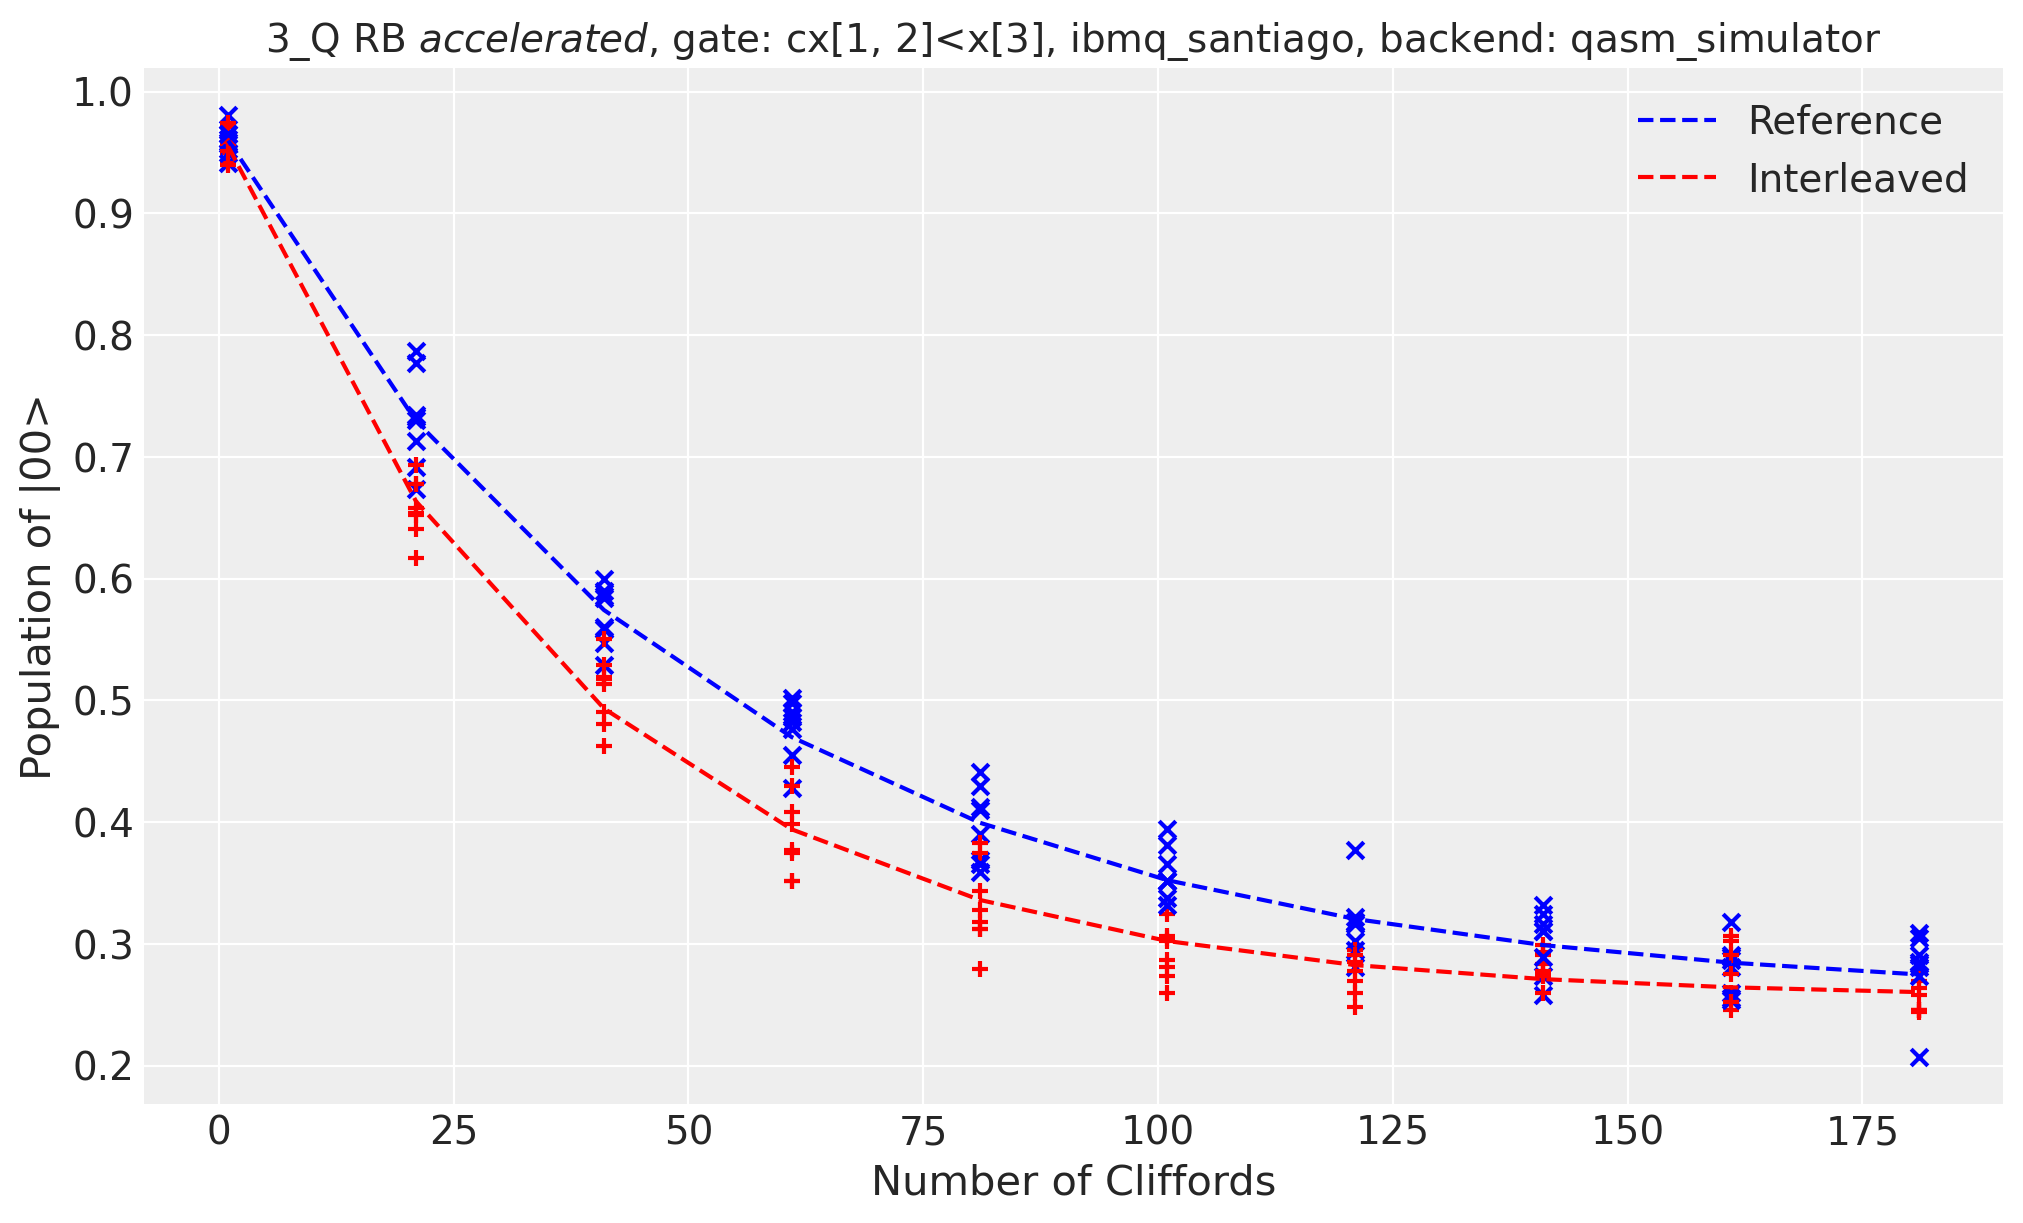

In [40]:
import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

#fig, plt = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
fig, plt = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

plt.set_ylabel("Population of |00>")
plt.set_xlabel("Number of Cliffords")

for i_seed in range(nseeds):
    plt.scatter(m_gates, Y1[i_seed,:]/shots, label = "data", marker="x",color="b")
    plt.scatter(m_gates, Y2[i_seed,:]/shots, label = "data", marker="+",color="r")
plt.plot(m_gates,azt_summary['mean']['AB[0]']*azt_summary['mean']['alpha']**m_gates+\
          azt_summary['mean']['AB[1]'],'--',color="b")
plt.plot(m_gates,azt_summary['mean']['AB[0]']*(azt_summary['mean']['alpha']*azt_summary['mean']['p_tilde'])**\
          m_gates+azt_summary['mean']['AB[1]'],'--',color="r")

plt.legend(("Reference",
             "Interleaved"))

plt.set_title(RB_process +' $accelerated$, gate: ' + intl_g\
                  +", "+hardware+', backend: '+backend.name(),
               fontsize=14)

In [36]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [37]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Apr 21 2021

Python implementation: CPython
Python version       : 3.8.1
IPython version      : 7.12.0

pymc3  : 3.11.1
numpy  : 1.18.1
qiskit : 0.23.0
arviz  : 0.11.2
IPython: 7.12.0

Watermark: 2.2.0

